#  Chest X-Ray Classification with VAE-Augmented Data

This project addresses the issue of class imbalance in chest X-ray datasets, specifically between "Normal" and "Pneumonia" cases. Deep learning models trained on such imbalanced data often perform poorly on the minority class. To mitigate this, we use a **Conditional Variational Autoencoder (VAE)** to generate synthetic images of the minority class (Normal).

The pipeline follows these stages:

1. **Train a Conditional VAE** using the imbalanced dataset.
2. **Generate synthetic Normal images** using the trained VAE.
3. **Augment the dataset** by adding synthetic samples to balance the classes.
4. **Train a CNN classifier** using both original and augmented datasets.
5. **Compare model performance** to assess the effect of VAE augmentation.

All training is done on **CPU**, so models and input sizes are optimized for speed and resource efficiency.

Key improvements applied:
- Early stopping to prevent VAE overfitting.
- Curriculum-style mixing to avoid overreliance on synthetic data early on.
- Class-weighted loss functions to compensate for imbalance.

## The workflow

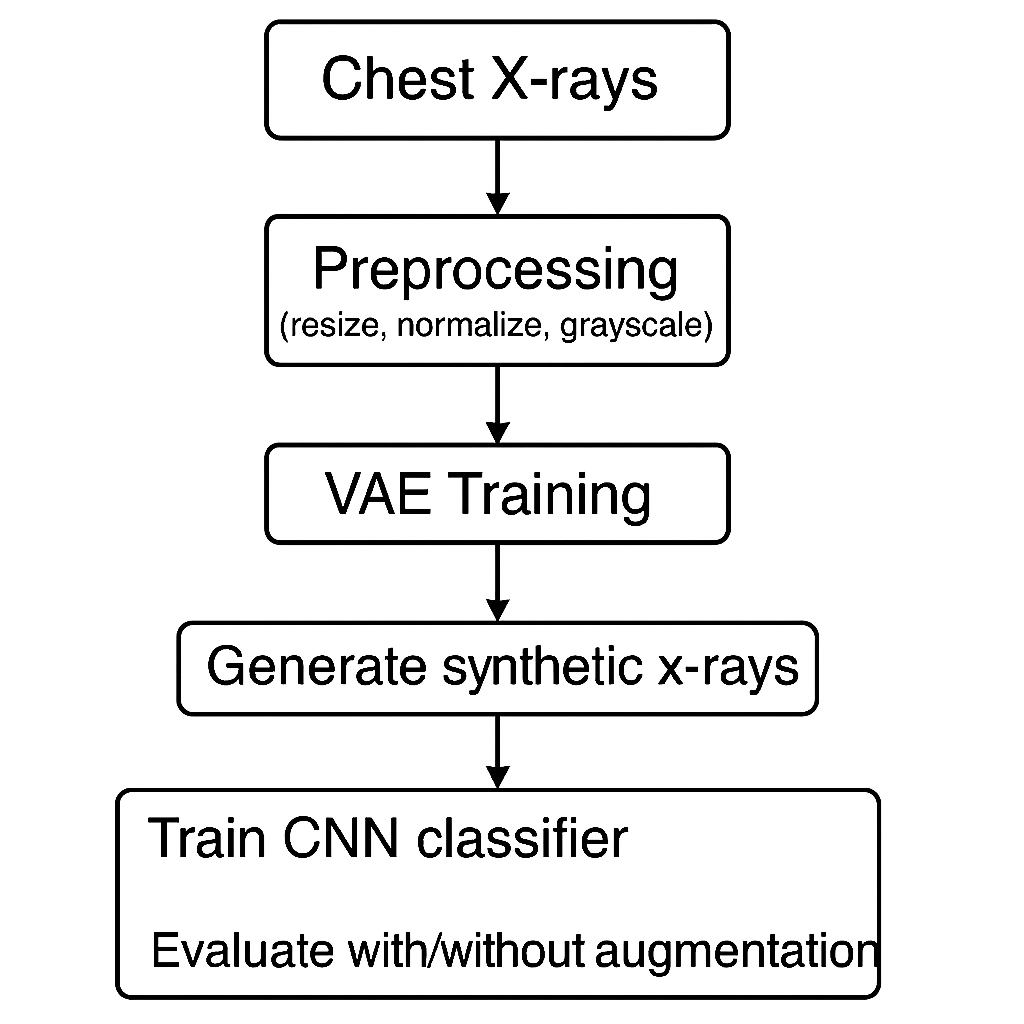

# Install requirements

In [1]:
!conda update -n base -c conda-forge conda -y

Retrieving notices: done
Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.0
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.7.9   |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.7.9           |     pyhd8ed1ab_0         153 KB  conda-forge
    conda-25.5.1               |  py312h7900ff3_0         1.1 MB  conda-forge
    openssl-3.5.1              |       h7b32b05_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.4 M

In [1]:
# !conda update -n base -c conda-forge conda
!conda install conda-forge::scikit-learn -y
!conda install conda-forge::pytorch -y
!conda install conda-forge::torchvision -y

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv

  added / updated specs:
    - conda-forge::scikit-learn


The following NEW packages will be INSTALLED:

  joblib             conda-forge/noarch::joblib-1.5.1-pyhd8ed1ab_0 
  scikit-learn       conda-forge/linux-64::scikit-learn-1.7.0-py310h27f47ee_1 
  scipy              conda-forge/linux-64::scipy-1.15.2-py310h1d65ade_0 
  setuptools         conda-forge/noarch::setuptools-80.9.0-pyhff2d567_0 
  threadpoolctl      conda-forge/noarch::threadpoolctl-3.6.0-pyhecae5ae_0 

The following packages will be UPDATED:

  ca-certificates                      2025.6.15-hbd8a1cb_0 --> 2025.7.9-hbd8a1cb_0 
  certifi                            2025.6.15-pyhd8ed1ab_0 --> 2025.7.9-pyhd8ed1ab_0 
  openssl                                  3.5.0-h7b32b05_1 --> 3.5.1-h7b32b05_0 




Preparing transaction: done
Verifying tran

In [10]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio torchmetrics --index-url https://download.pytorch.org/whl/cu121
import torch

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchmetrics] [torchmetrics]


In [ ]:
import sys
!{sys.executable} -m pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 167.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]


In [ ]:
import os
import shutil

for root, dirs, files in os.walk('.'):
    for d in dirs:
        if d == '.ipynb_checkpoints':
            path = os.path.join(root, d)
            print(f'Removing: {path}')
            shutil.rmtree(path)


Removing: ./.ipynb_checkpoints
Removing: ./chest_xray/.ipynb_checkpoints
Removing: ./chest_xray/test/.ipynb_checkpoints
Removing: ./chest_xray/train/.ipynb_checkpoints
Removing: ./chest_xray/val/.ipynb_checkpoints


In [19]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torchvision.utils as vutils
import psutil
import gc

# Visualizing the data

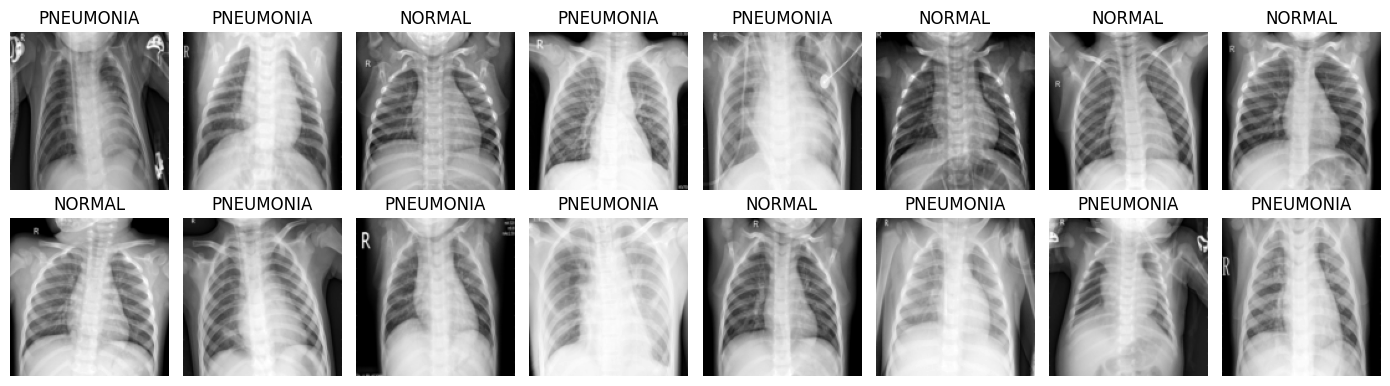

In [7]:
# Preprocessing
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
dataset = datasets.ImageFolder(root="chest_xray/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Visualize Batch
images, labels = next(iter(dataloader))
images = images * 0.5 + 0.5  # Denormalize to [0,1]

# Plot
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap='gray')
    ax.set_title(dataset.classes[labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Data preprocessing

### 🖼️ Image Preprocessing and Normalization

This block defines the preprocessing applied to each image:

- **Resize to 64×64**: Smaller images reduce memory usage and training time on CPU.
- **Grayscale conversion**: Converts RGB to a single channel.
- **Normalization to [−1, 1]**: Essential to match the `Tanh()` activation in the VAE decoder.


### Load Chest X-ray Training Set

This block uses `ImageFolder` to load chest X-ray images from a directory structured like:

- chest_xray/train/
    - Normal/
    - Pneumonia/

In [8]:
# Section 1: Dataset Preparation
data_dir = "chest_xray"  # Update with your dataset path after downloading

# Define transforms: resize to 128x128, ensure grayscale, normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # [0, 1] to [-1, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class distribution
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
print("Class distribution:", class_counts)  # Counter({1: 3875, 0: 1341})
num_normal = class_counts[0]
num_pneumonia = class_counts[1]
num_synthetic = num_pneumonia - num_normal  # 2534 synthetic "NORMAL" images

Class distribution: Counter({1: 3875, 0: 1341})


# DDPM (It was a trial, ignore it )

In [2]:
# Class-Conditional DDPM
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, time_emb_dim=32):
        super(UNet, self).__init__()
        self.time_emb_dim = time_emb_dim

        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Downsampling
        self.down1 = DoubleConv(2, 32)  # 2 channels: image + class map
        self.time_emb_down1 = nn.Linear(time_emb_dim, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.time_emb_down2 = nn.Linear(time_emb_dim, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(64, 128)
        self.time_emb_down3 = nn.Linear(time_emb_dim, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(128, 256)
        self.time_emb_down4 = nn.Linear(time_emb_dim, 256)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        self.time_emb_bottleneck = nn.Linear(time_emb_dim, 512)

        # Upsampling
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv_up1 = DoubleConv(512, 256)
        self.time_emb_up1 = nn.Linear(time_emb_dim, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv_up2 = DoubleConv(256, 128)
        self.time_emb_up2 = nn.Linear(time_emb_dim, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_up3 = DoubleConv(128, 64)
        self.time_emb_up3 = nn.Linear(time_emb_dim, 64)
        self.up4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv_up4 = DoubleConv(64, 32)
        self.time_emb_up4 = nn.Linear(time_emb_dim, 32)

        # Final conv
        self.final_conv = nn.Conv2d(32, 1, 1)

    def forward(self, x, t, labels):
        batch_size, _, h, w = x.shape
        class_map = labels.view(batch_size, 1, 1, 1).float().expand(batch_size, 1, h, w)
        x = torch.cat([x, class_map], dim=1)  # [B, 2, H, W]
        t = t.float() / 200.0  # Normalize for T=200
        t_emb = self.time_mlp(t.unsqueeze(-1))
        d1 = self.down1(x) + self.time_emb_down1(t_emb).view(-1, 32, 1, 1)
        p1 = self.pool1(d1)
        d2 = self.down2(p1) + self.time_emb_down2(t_emb).view(-1, 64, 1, 1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2) + self.time_emb_down3(t_emb).view(-1, 128, 1, 1)
        p3 = self.pool3(d3)
        d4 = self.down4(p3) + self.time_emb_down4(t_emb).view(-1, 256, 1, 1)
        p4 = self.pool4(d4)
        b = self.bottleneck(p4) + self.time_emb_bottleneck(t_emb).view(-1, 512, 1, 1)
        u1 = self.up1(b)
        u1 = torch.cat([u1, d4], dim=1)
        u1 = self.conv_up1(u1) + self.time_emb_up1(t_emb).view(-1, 256, 1, 1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d3], dim=1)
        u2 = self.conv_up2(u2) + self.time_emb_up2(t_emb).view(-1, 128, 1, 1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d2], dim=1)
        u3 = self.conv_up3(u3) + self.time_emb_up3(t_emb).view(-1, 64, 1, 1)
        u4 = self.up4(u3)
        u4 = torch.cat([u4, d1], dim=1)
        u4 = self.conv_up4(u4) + self.time_emb_up4(t_emb).view(-1, 32, 1, 1)
        return self.final_conv(u4)

class DDPM(nn.Module):
    def __init__(self, T=200, beta_start=1e-4, beta_end=0.02, img_size=128, time_emb_dim=32, device="cpu"):
        super(DDPM, self).__init__()
        self.T = T
        self.device = device
        self.img_size = img_size
        self.beta = torch.linspace(beta_start, beta_end, T, device=device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        self.one_over_sqrt_alpha = 1 / torch.sqrt(self.alpha)
        self.coef1 = (1 - self.alpha) / torch.sqrt(1 - self.alpha_bar)
        self.sigma = torch.sqrt(self.beta)
        self.unet = UNet(time_emb_dim=time_emb_dim).to(device)

    def add_noise(self, x, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t-1].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t-1].view(-1, 1, 1, 1)
        epsilon = torch.randn_like(x)
        x_t = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * epsilon
        return x_t, epsilon

    def sample_timesteps(self, batch_size):
        return torch.randint(1, self.T + 1, (batch_size,), device=self.device)

    def train_step(self, x, labels, optimizer):
        t = self.sample_timesteps(x.size(0))
        x_t, epsilon = self.add_noise(x, t)
        epsilon_pred = self.unet(x_t, t, labels)
        loss = F.mse_loss(epsilon_pred, epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    def sample_ddim(self, num_samples, class_label, device, steps=10):
        try:
            # DDIM sampling with fewer steps
            step_size = self.T // steps
            timesteps = torch.arange(self.T-1, -1, -step_size, device=device)
            x = torch.randn(num_samples, 1, self.img_size, self.img_size, device=device)
            labels = torch.full((num_samples,), class_label, dtype=torch.long, device=device)
            for i, t in enumerate(timesteps):
                t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
                with torch.no_grad():
                    epsilon_pred = self.unet(x, t_tensor, labels)
                alpha_bar_t = self.alpha_bar[t]
                alpha_bar_t_prev = self.alpha_bar[max(t-step_size, 0)]
                x = (x - (1 - alpha_bar_t) / torch.sqrt(1 - alpha_bar_t) * epsilon_pred) * torch.sqrt(alpha_bar_t_prev / alpha_bar_t)
                if t > 0:
                    sigma_t = torch.sqrt((1 - alpha_bar_t_prev) / (1 - alpha_bar_t) * (1 - alpha_bar_t / alpha_bar_t_prev))
                    z = torch.randn_like(x)
                    x = x + sigma_t * z
                print(f"DDIM Sampling Step {i+1}/{len(timesteps)}, Memory: {psutil.virtual_memory().percent}%")
                if torch.isnan(x).any() or torch.isinf(x).any():
                    raise ValueError(f"NaN or Inf detected at step {i+1}")
                # Clear intermediate tensors
                del epsilon_pred, t_tensor
                gc.collect()
            return x.detach()
        except Exception as e:
            print(f"Error in DDIM sampling: {str(e)}")
            raise

    def sample(self, num_samples, class_label, device, batch_size=100):
        try:
            # Batch sampling to reduce memory usage
            synthetic_images = []
            remaining_samples = num_samples
            while remaining_samples > 0:
                current_batch_size = min(batch_size, remaining_samples)
                print(f"Generating {current_batch_size} samples, {remaining_samples} remaining, Memory: {psutil.virtual_memory().percent}%")
                batch_images = self.sample_ddim(current_batch_size, class_label, device, steps=10)
                synthetic_images.append(batch_images)
                remaining_samples -= current_batch_size
                gc.collect()  # Force garbage collection
            return torch.cat(synthetic_images, dim=0)
        except Exception as e:
            print(f"Error in sample: {str(e)}")
            raise

# # Train DDPM, Generate Synthetic Images
device = "cpu"

# Train DDPM
print(f"Memory before DDPM training: {psutil.virtual_memory().percent}%")
ddpm = DDPM(T=200, img_size=128, device=device)
ddpm_optimizer = torch.optim.Adam(ddpm.unet.parameters(), lr=1e-4)
ddpm_epochs = 1
for epoch in range(ddpm_epochs):
    ddpm_loss_total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        loss = ddpm.train_step(images, labels, ddpm_optimizer)
        ddpm_loss_total += loss
    print(f"DDPM Epoch {epoch+1}, Loss: {ddpm_loss_total / len(train_loader)}")
print(f"Memory after DDPM training: {psutil.virtual_memory().percent}%")
gc.collect()

# Generate DDPM synthetic images
print(f"Memory before DDPM sampling: {psutil.virtual_memory().percent}%")
try:
    ddpm_synthetic_normal = ddpm.sample(num_synthetic, class_label=0, device=device, batch_size=100).detach()
    vutils.save_image(ddpm_synthetic_normal, "ddpm_synthetic_normal.png", normalize=True)
except Exception as e:
    print(f"Failed to generate DDPM images: {str(e)}")
    raise
print(f"Memory after DDPM sampling: {psutil.virtual_memory().percent}%")
gc.collect()

# Section 5: Create Augmented Datasets
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels

normal_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
normal_dataset = torch.utils.data.Subset(train_dataset, normal_indices)
ddpm_synthetic_labels = [0] * num_synthetic  # Use Python list of integers for labels
ddpm_synthetic_dataset = TensorDataset(ddpm_synthetic_normal, torch.tensor(ddpm_synthetic_labels, dtype=torch.long))
ddpm_augmented_dataset = ConcatDataset([train_dataset, ddpm_synthetic_dataset])
ddpm_augmented_loader = DataLoader(ddpm_augmented_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

# Section 6: Train CNN Classifier
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_classifier(model, train_loader, test_loader, epochs=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Classifier Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return accuracy, precision, recall, f1

# Train classifiers
print("Training classifier on original dataset")
cnn_original = SimpleCNN()
orig_metrics = train_classifier(cnn_original, train_loader, test_loader)


print("Training classifier on DDPM-augmented dataset")
cnn_ddpm = SimpleCNN()
ddpm_metrics = train_classifier(cnn_ddpm, ddpm_augmented_loader, test_loader)

# Section 7: Print Evaluation Results
print("\nEvaluation Results:")
print(f"Original Dataset - Accuracy: {orig_metrics[0]:.4f}, Precision: {orig_metrics[1]:.4f}, Recall: {orig_metrics[2]:.4f}, F1: {orig_metrics[3]:.4f}")
print(f"DDPM-Augmented - Accuracy: {ddpm_metrics[0]:.4f}, Precision: {ddpm_metrics[1]:.4f}, Recall: {ddpm_metrics[2]:.4f}, F1: {ddpm_metrics[3]:.4f}")

# Save models
torch.save(ddpm.state_dict(), "ddpm_model.pth")
torch.save(cnn_original.state_dict(), "cnn_original.pth")
torch.save(cnn_ddpm.state_dict(), "cnn_ddpm.pth")


Class distribution: Counter({1: 3875, 0: 1341})
Memory before DDPM training: 23.3%
DDPM Epoch 1, Loss: 0.2788375696978686
Memory after DDPM training: 34.9%
Memory before DDPM sampling: 34.9%
Generating 100 samples, 2534 remaining, Memory: 34.9%
DDIM Sampling Step 1/10, Memory: 34.9%
DDIM Sampling Step 2/10, Memory: 34.9%
DDIM Sampling Step 3/10, Memory: 34.9%
DDIM Sampling Step 4/10, Memory: 34.9%
DDIM Sampling Step 5/10, Memory: 34.9%
DDIM Sampling Step 6/10, Memory: 34.9%
DDIM Sampling Step 7/10, Memory: 34.9%
DDIM Sampling Step 8/10, Memory: 34.9%
DDIM Sampling Step 9/10, Memory: 34.9%
DDIM Sampling Step 10/10, Memory: 34.9%
Generating 100 samples, 2434 remaining, Memory: 34.9%
DDIM Sampling Step 1/10, Memory: 34.9%
DDIM Sampling Step 2/10, Memory: 34.9%
DDIM Sampling Step 3/10, Memory: 34.9%
DDIM Sampling Step 4/10, Memory: 34.9%
DDIM Sampling Step 5/10, Memory: 34.9%
DDIM Sampling Step 6/10, Memory: 34.9%
DDIM Sampling Step 7/10, Memory: 34.9%
DDIM Sampling Step 8/10, Memory: 34.9

# VAE

### Conditional VAE Architecture

This code defines a **Conditional Variational Autoencoder** with the following structure:

- The **encoder** uses 3 convolutional layers followed by 2 linear layers:
  - The convolutions downsample the input from 64×64 to 8×8 resolution.
  - The output is flattened and passed through two fully connected layers to compute:
    - `μ` (mean of the latent distribution)
    - `log(σ²)` (log-variance of the latent distribution)

- The **reparameterization trick** samples latent vectors `z` from the posterior using:

  `z = μ + σ * ε`, where `ε ~ N(0, 1)`

  This formulation enables gradient backpropagation through the stochastic sampling process.

- The **decoder** takes the latent code `z`, concatenates it with a **one-hot encoded class label**, and upsamples it through:
  - Fully connected layers followed by transposed convolutions
  - A final `Tanh()` activation, which outputs images in the range [−1, 1] to match the normalized input

This model enables class-conditional generation — for example, synthesizing new chest X-rays labeled “Normal”.

### VAE Loss Function: Reconstruction + KL Divergence

This custom loss combines two components:

1. **Reconstruction Loss**: Mean Squared Error (MSE) between the input `x` and the reconstruction `x̂`. MSE is preferred over Binary Cross-Entropy (BCE) because:
   - The pixel intensities are normalized to [−1, 1] using `Tanh()`
   - MSE offers smoother gradients, especially for natural images

2. **KL Divergence**:
   - Measures how much the learned latent distribution `q(z|x)` deviates from a standard normal prior `N(0, I)`
   - Computed analytically from the predicted mean `μ` and log-variance `log(σ²)`
   - Encourages latent vectors to be normally distributed, improving generalization and interpolation
   - The KL term is weighted by a small factor (`kl_weight = 0.05`) to reduce blur and over-regularization

**Total Loss Function**:

`Loss = MSE(x, x̂) + λ * KL(N(μ, σ²) || N(0, I))`

Where:
- `x` is the original image,
- `x̂` is the reconstruction,
- `μ` and `σ²` are the encoder's output parameters,
- `λ` is the KL weight (typically small to balance image sharpness and latent structure).



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import torchvision.utils as vutils

# Set device to CPU since no GPU is available
device = torch.device("cpu")

# Define a simple Conditional VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=256, num_classes=2):  # Latent size 256, 2 classes (Normal/Pneumonia)
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim  # Size of the latent space
        self.num_classes = num_classes  # Number of classes (e.g., 2 for Normal/Pneumonia)

        # Encoder: Turns image into a smaller representation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),  # [1, 64, 64] -> [16, 32, 32]
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),  # -> [32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # -> [64, 8, 8]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim)  # Output mu and log_variance
        )
        
        # Decoder: Turns latent code + class back into an image
        self.decoder_input = nn.Linear(latent_dim + num_classes, 128)
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # -> [32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # -> [16, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),   # -> [1, 64, 64]
            nn.Tanh()  # Output between -1 and 1
        )

    def encode(self, x):  # Get mu and log_variance from image
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)  # Split into mu and log_variance
        return mu, log_var

    def reparameterize(self, mu, log_var):  # Add randomness to latent space
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):  # Rebuild image with class info
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()  # Convert labels to one-hot
        z = torch.cat([z, labels_onehot], dim=1)  # Combine latent code with class
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x, labels):  # Full process: encode, sample, decode
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z, labels)
        return x_recon, mu, log_var

    def sample(self, num_samples, class_label, device):  # Generate new images
        z = torch.randn(num_samples, self.latent_dim).to(device)
        labels = torch.full((num_samples,), class_label, dtype=torch.long).to(device)
        return self.decode(z, labels)

# Loss function: Reconstruction error + KL divergence
def vae_loss(recon_x, x, mu, log_var, kl_weight=0.05):  # Small KL to reduce blur
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # MSE for image quality
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # Keep latent space regular
    return recon_loss + kl_weight * kl_loss

# Prepare data: Resize to 64x64 for faster CPU training
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Smaller size for speed
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.ImageFolder("chest_xray/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Set number of synthetic images
num_synthetic = 2534  # Match your augmentation needs

# Train the VAE with early stopping to avoid blurry results
vae = ConditionalVAE(latent_dim=256, num_classes=2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
best_loss = float('inf')  # Track the lowest loss
patience = 3  # Stop if loss doesn’t improve for 3 epochs
trials = 0

for epoch in range(20):  # Start with 10 epochs, stop early if needed
    vae.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        recon_x, mu, log_var = vae(images, labels)  # Get reconstructed image and latent vars
        loss = vae_loss(recon_x, images, mu, log_var)  # Calculate loss
        loss.backward()  # Update model
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    
    # Early stopping: Save if loss improves, stop if it doesn’t
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(vae.state_dict(), "best_vae.pth")
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Stopping early at Epoch {epoch+1} to keep quality")
            break
    
    # Save images to check quality each epoch
    with torch.no_grad():
        samples = vae.sample(8, class_label=0, device=device)  # Generate 8 "Normal" images
        vutils.save_image(samples, f"epoch_{epoch+1}_normal.png", normalize=True)

# Load best model and generate final synthetic images
vae.load_state_dict(torch.load("best_vae.pth"))
vae.eval()
with torch.no_grad():
    vae_synthetic_normal = vae.sample(num_synthetic, class_label=0, device=device).detach()
    vutils.save_image(vae_synthetic_normal, "vae_synthetic_normal.png", normalize=True)

# Create augmented dataset
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels

vae_synthetic_labels = [0] * num_synthetic  # All synthetic images are "Normal"
vae_synthetic_dataset = TensorDataset(vae_synthetic_normal.cpu(), torch.tensor(vae_synthetic_labels))
vae_augmented_dataset = ConcatDataset([train_dataset, vae_synthetic_dataset])
vae_augmented_loader = DataLoader(vae_augmented_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

# Save the final model
torch.save(vae.state_dict(), "vae_model.pth")

Epoch 1, Average Loss: 263.1871
Epoch 2, Average Loss: 131.6849
Epoch 3, Average Loss: 109.4366
Epoch 4, Average Loss: 93.5671
Epoch 5, Average Loss: 85.8236
Epoch 6, Average Loss: 80.7809
Epoch 7, Average Loss: 76.2150
Epoch 8, Average Loss: 72.1962
Epoch 9, Average Loss: 69.9179
Epoch 10, Average Loss: 68.1072
Epoch 11, Average Loss: 66.4710
Epoch 12, Average Loss: 64.5558
Epoch 13, Average Loss: 63.1673
Epoch 14, Average Loss: 62.2740
Epoch 15, Average Loss: 60.5317
Epoch 16, Average Loss: 59.5402
Epoch 17, Average Loss: 59.0636
Epoch 18, Average Loss: 57.4912
Epoch 19, Average Loss: 57.2932
Epoch 20, Average Loss: 55.8196


/tmp/ipykernel_30726/3557369289.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_vae.pth"))


## retrain VAE pretrained

In [30]:
# Load pre-trained model and continue training
vae = ConditionalVAE(latent_dim=256, num_classes=2).to(device)
vae.load_state_dict(torch.load("best_vae_30.pth"))  # Load pre-trained weights
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
best_loss = float('inf')  # Track the lowest loss
patience = 3  # Stop if loss doesn’t improve for 3 epochs
trials = 0

# Continue training from the loaded model
for epoch in range(1):  # Continue for 30 more epochs or adjust as needed
    vae.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        recon_x, mu, log_var = vae(images, labels)  # Get reconstructed image and latent vars
        loss = vae_loss(recon_x, images, mu, log_var)  # Calculate loss
        loss.backward()  # Update model
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+31}, Average Loss: {avg_loss:.4f}")
    
    # Early stopping: Save if loss improves, stop if it doesn’t
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(vae.state_dict(), "best_vae_30.pth")
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Stopping early at Epoch {epoch+31} to keep quality")
            break
    
    # Save images to check quality each epoch
    with torch.no_grad():
        samples = vae.sample(8, class_label=0, device=device)  # Generate 8 "Normal" images
        vutils.save_image(samples, f"epoch_{epoch+31}_normal.png", normalize=True)

# Load best model and generate final synthetic images
vae.load_state_dict(torch.load("best_vae_30.pth"))
vae.eval()
with torch.no_grad():
    vae_synthetic_normal = vae.sample(num_synthetic, class_label=0, device=device).detach()
    vutils.save_image(vae_synthetic_normal, "vae_synthetic_normal_30.png", normalize=True)

# Create augmented dataset
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels

vae_synthetic_labels = [0] * num_synthetic  # All synthetic images are "Normal"
vae_synthetic_dataset = TensorDataset(vae_synthetic_normal.cpu(), torch.tensor(vae_synthetic_labels))
vae_augmented_dataset = ConcatDataset([train_dataset, vae_synthetic_dataset])
vae_augmented_loader = DataLoader(vae_augmented_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

# Save the final model
torch.save(vae.state_dict(), "vae_model_30.pth")

/tmp/ipykernel_26035/2154173357.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_vae_30.pth"))  # Load pre-trained weights


Epoch 31, Average Loss: 48.7207


/tmp/ipykernel_26035/2154173357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_vae_30.pth"))


## Train Classifier

### Training and Evaluating a Simple CNN Classifier

This block defines, trains, and evaluates a lightweight convolutional neural network (CNN) for binary classification of chest X-ray images (Normal vs. Pneumonia). It performs training on both the original imbalanced dataset and the VAE-augmented dataset to compare performance.

#### Model Definition: `SimpleCNN`

The model has two main parts:

1. **Convolutional Feature Extractor**:
   - `Conv2d(1, 16, 3, padding=1)`: Input is a single-channel grayscale image (1 × 64 × 64). Outputs 16 feature maps of the same size.
   - `MaxPool2d(2)`: Reduces spatial size to 32 × 32.
   - Another convolution and pooling layer follows, resulting in an output of shape (32 × 16 × 16).

2. **Fully Connected Classifier**:
   - The flattened 32×16×16 tensor is passed through a linear layer to reduce to 128 features.
   - A final `Linear(128, 2)` layer outputs logits for 2 classes: **Normal** (label 0) and **Pneumonia** (label 1).

The model is compact and optimized for CPU use with limited memory, making it suitable for quick prototyping or educational settings.

#### Training Function: `train_classifier(...)`

This function accepts:
- A CNN model,
- A training DataLoader (`train_loader`),
- A test DataLoader (`test_loader`),
- A number of training epochs (default is 5).

**Training Loop**:
- Uses `CrossEntropyLoss` as the objective function for classification.
- The optimizer is Adam with a learning rate of 0.001.
- For each epoch:
  - Sets the model to training mode with `model.train()`.
  - For every batch:
    - Clears gradients, computes predictions, evaluates loss, and updates weights.
  - Prints the average loss per epoch.

**Evaluation Loop**:
- Switches to evaluation mode with `model.eval()`.
- Disables gradient tracking with `torch.no_grad()`.
- Computes accuracy on the test dataset.

#### Comparison: Original vs. VAE-Augmented Training

The classifier is trained twice:
1. **On the original dataset** (which is class-imbalanced),
2. **On the VAE-augmented dataset**, where synthetic "Normal" samples are added to balance the classes.

The goal is to compare the effectiveness of VAE-based data augmentation.


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set device to CPU since no GPU is available
device = torch.device("cpu")

# Define a simple CNN classifier
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # [1, 64, 64] -> [16, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),                 # -> [16, 32, 32]
            nn.Conv2d(16, 32, 3, padding=1), # -> [32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                 # -> [32, 16, 16]
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),    # Flatten and connect
            nn.ReLU(),
            nn.Linear(128, 2)                # 2 classes: Normal/Pneumonia
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Train the classifier function
def train_classifier(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()  # Loss for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)

    for epoch in range(epochs):
        model.train()  # Set to training mode
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Clear old gradients
            outputs = model(images)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Update weights
            optimizer.step()
            total_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Evaluate on test set
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient needed for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")
    return accuracy  # Return accuracy for comparison


# Train and evaluate classifiers
print("Training classifier on original dataset")
cnn_original = SimpleCNN()
orig_metrics = train_classifier(cnn_original, train_loader, test_loader)

print("Training classifier on VAE-augmented dataset")
cnn_vae = SimpleCNN()
vae_metrics = train_classifier(cnn_vae, vae_augmented_loader, test_loader)

# Save models
torch.save(cnn_original.state_dict(), "cnn_original.pth")
torch.save(cnn_vae.state_dict(), "cnn_vae.pth")

Training classifier on original dataset
Epoch 1/5, Loss: 0.2045
Epoch 2/5, Loss: 0.1022
Epoch 3/5, Loss: 0.0884
Epoch 4/5, Loss: 0.0681
Epoch 5/5, Loss: 0.0598
Accuracy on test set: 0.7484
Training classifier on VAE-augmented dataset
Epoch 1/5, Loss: 0.2599
Epoch 2/5, Loss: 0.1167
Epoch 3/5, Loss: 0.0811
Epoch 4/5, Loss: 0.0598
Epoch 5/5, Loss: 0.0500
Accuracy on test set: 0.7532


## Prediction

### Validation Accuracy and Visual Comparison of Predictions

In this section, we:
1. Load and preprocess a separate **validation dataset**,
2. Evaluate both models (trained on original and VAE-augmented data),
3. Visualize their predictions for a few individual chest X-ray images.

#### Loading the Validation Dataset

We use `ImageFolder` to load images from `chest_xray/val`. The same transformations are applied as in training:
- **Resize to 64×64** to match the input size expected by the CNN,
- **Convert to grayscale**,
- **Convert to tensor**.


#### Accuracy Evaluation

The function `evaluate_accuracy()`:
- Iterates over the validation data with the model in `eval()` mode (inference-only),
- Predicts the class for each image,
- Compares predictions to ground truth,
- Returns total accuracy as:  
  `accuracy = correct_predictions / total_samples`

This is done for both:
- `cnn_original`: trained on original imbalanced data,
- `cnn_vae`: trained on VAE-augmented balanced data.

Printed results allow a quick numeric comparison of the models' generalization.

#### Visualizing Predictions

The function `plot_validation_results()` shows qualitative results:

- Loads a few images from the validation set (default: 5).
- Displays them one by one in a vertical stack using `matplotlib`.
- For each image, it shows:
  - **True label** (from validation ground truth),
  - **Prediction from the original model**,
  - **Prediction from the VAE-augmented model**.


Original Accuracy: 0.5000
VAE-Augmented Accuracy: 0.6250


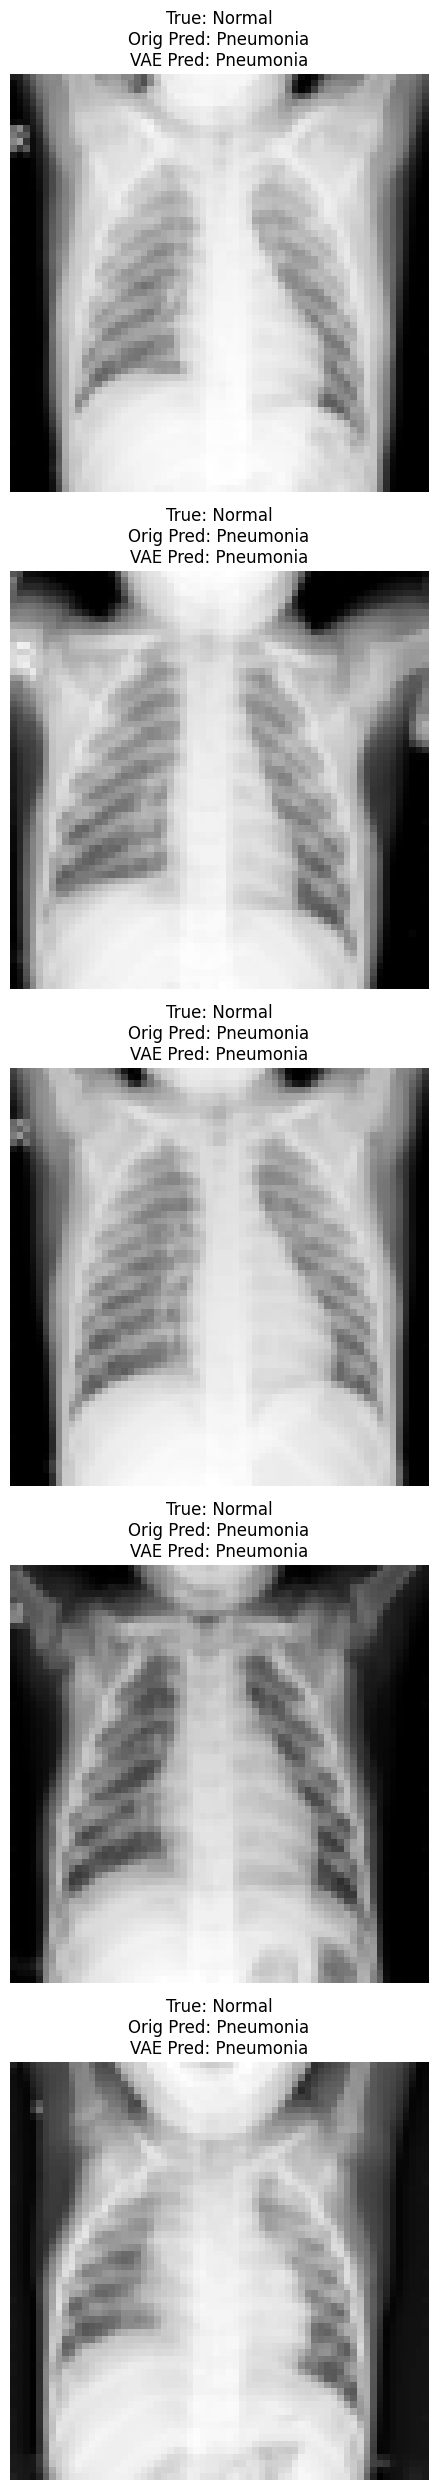

In [9]:
# Load Validation Dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 to match SimpleCNN's expected input
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
val_dataset = datasets.ImageFolder("chest_xray/val", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Batch size 1 for individual images

# Evaluate Accuracy
def evaluate_accuracy(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Calculate accuracies
orig_accuracy = evaluate_accuracy(cnn_original, val_loader)
vae_accuracy = evaluate_accuracy(cnn_vae, val_loader)
print(f"Original Accuracy: {orig_accuracy:.4f}")
print(f"VAE-Augmented Accuracy: {vae_accuracy:.4f}")

# Reset loader for visualization
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Visualization Function
def plot_validation_results(val_loader, cnn_original, cnn_vae, device, num_images=5):
    val_images = []
    val_labels = []
    orig_preds = []
    vae_preds = []
    
    # Collect data and predictions
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val_images.append(images.cpu().squeeze())
            val_labels.append(labels.item())
            orig_pred = torch.argmax(cnn_original(images), dim=1).item()
            vae_pred = torch.argmax(cnn_vae(images), dim=1).item()
            orig_preds.append(orig_pred)
            vae_preds.append(vae_pred)
            if len(val_images) >= num_images:
                break
    
    # Create plot
    fig, axes = plt.subplots(num_images, 1, figsize=(5, 5 * num_images))
    for i in range(num_images):
        axes[i].imshow(val_images[i], cmap="gray")
        true_label = "Normal" if val_labels[i] == 0 else "Pneumonia"
        orig_pred = "Normal" if orig_preds[i] == 0 else "Pneumonia"
        vae_pred = "Normal" if vae_preds[i] == 0 else "Pneumonia"
        axes[i].set_title(f"True: {true_label}\nOrig Pred: {orig_pred}\nVAE Pred: {vae_pred}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.savefig("val_results.png")
    plt.show()

# Show Results
plot_validation_results(val_loader, cnn_original, cnn_vae, device, num_images=5)

# VAE after improvement

### Enhanced Conditional VAE with Residual Blocks and SSIM-Based Loss
This section defines and trains a more expressive **Conditional Variational Autoencoder (VAE)** that leverages:
- **Residual blocks** in the decoder for sharper image reconstruction,
- **SSIM (Structural Similarity Index)** as a secondary loss term to preserve image structure,
- **β-VAE regularization**, and
- Early stopping based on validation loss.

---

#### Network Enhancements: Residual Decoder Blocks

A `ResidualBlock` class is defined for use in the decoder:
- It uses **two ConvTranspose2D layers** with a residual skip connection (identity or 1×1 conv).
- This helps preserve feature integrity during upsampling and reduces vanishing gradients.
- Two such blocks are applied at 8×8 and 16×16 resolutions in the decoder.

---

#### VAE Architecture (Encoder + Decoder)

**Encoder**:
- Consists of 3 convolutional layers reducing 64×64 input to 8×8, followed by fully connected layers to compute:
  - Mean (`μ`) and
  - Log-variance (`log(σ²)`) of the latent distribution.

**Decoder**:
- Accepts a concatenated latent vector `z` + one-hot encoded class label.
- The decoding path includes:
  - A fully connected expansion to 8×8×64,
  - Residual blocks at two spatial resolutions,
  - Three upsampling layers using transposed convolutions,
  - Final `Tanh()` activation to produce output in the range [−1, 1].

This setup improves reconstruction quality without significantly increasing computational load, keeping it viable for CPU-based training.

---

### Custom Loss Function: MSE + SSIM + KL Divergence

The training objective for the enhanced VAE combines **three complementary losses** to produce sharper, more realistic reconstructions while maintaining a well-behaved latent space.



##### 1. **MSE Loss (Mean Squared Error)**
- Used as the primary **pixel-wise reconstruction loss**:  
  `recon_loss_mse = F.mse_loss(recon_x, x, reduction='sum')`
- Measures the average squared difference between the reconstructed image `recon_x` and the ground truth image `x`.

##### 2. **SSIM Loss (Structural Similarity Index Measure)**
- SSIM evaluates perceptual image quality by comparing **local patterns of pixel intensities**, including:
  - **Luminance**
  - **Contrast**
  - **Structural information**

- In the code:
  ```python
  ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
  recon_loss_ssim = 1.0 - ssim(recon_x, x)


The final formula is:

```text
Loss = MSE(x̂, x) + ssim_weight * (1 - SSIM(x̂, x)) + β * KL(N(μ, σ²) || N(0, I))


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchmetrics.image import StructuralSimilarityIndexMeasure  # For SSIM

# Set device to CPU since no GPU is available
device = torch.device("cpu")

# Define a Residual Block for the decoder
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1)
        self.downsample = nn.ConvTranspose2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Residual connection
        out = self.relu(out)
        return out

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=256, num_classes=2):  # Latent size 256, 2 classes (Normal/Pneumonia)
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim  # Size of the latent space
        self.num_classes = num_classes  # Number of classes (e.g., 2 for Normal/Pneumonia)

        # Encoder: Turns image into a smaller representation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),  # [1, 64, 64] -> [16, 32, 32]
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),  # -> [32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # -> [64, 8, 8]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim)  # Output mu and log_variance
        )
        
        # Decoder: Turns latent code + class back into an image with two residual blocks
        self.decoder_input = nn.Linear(latent_dim + num_classes, 128)
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            ResidualBlock(64, 64),  # First residual block at 8x8 resolution
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # -> [32, 16, 16]
            nn.ReLU(),
            ResidualBlock(32, 32),  # Second residual block at 16x16 resolution
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # -> [16, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),   # -> [1, 64, 64]
            nn.Tanh()  # Output between -1 and 1
        )

    def encode(self, x):  # Get mu and log_variance from image
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)  # Split into mu and log_variance
        return mu, log_var

    def reparameterize(self, mu, log_var):  # Add randomness to latent space
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):  # Rebuild image with class info
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()  # Convert labels to one-hot
        z = torch.cat([z, labels_onehot], dim=1)  # Combine latent code with class
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x, labels):  # Full process: encode, sample, decode
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z, labels)
        return x_recon, mu, log_var

    def sample(self, num_samples, class_label, device):  # Generate new images
        z = torch.randn(num_samples, self.latent_dim).to(device)
        labels = torch.full((num_samples,), class_label, dtype=torch.long).to(device)
        return self.decode(z, labels)

# Enhanced loss function with SSIM and β-VAE
def vae_loss(recon_x, x, mu, log_var, beta=1.0, ssim_weight=0.1):  # Reverted to beta=1.0
    recon_loss_mse = F.mse_loss(recon_x, x, reduction='sum')  # Pixel-wise loss
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)  # SSIM for structural similarity
    recon_loss_ssim = 1.0 - ssim(recon_x, x)  # Convert SSIM to loss (lower is better)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    total_loss = recon_loss_mse + ssim_weight * recon_loss_ssim + beta * kl_loss  # Weighted combination
    return total_loss

# Prepare data: Resize to 64x64 for faster CPU training
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Smaller size for speed
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.ImageFolder("chest_xray/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Set number of synthetic images
num_synthetic = 2534  # Match your augmentation needs

# Train the VAE with early stopping to avoid blurry results
vae = ConditionalVAE(latent_dim=256, num_classes=2).to(device)
# vae.load_state_dict(torch.load("updated_vae_model.pth"))  # Load pre-trained weights

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
best_loss = float('inf')  # Track the lowest loss
patience = 3  # Stop if loss doesn’t improve for 3 epochs
trials = 0

for epoch in range(30):  # Keep at 20 epochs for more training
    vae.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        recon_x, mu, log_var = vae(images, labels)  # Get reconstructed image and latent vars
        loss = vae_loss(recon_x, images, mu, log_var, beta=1.0, ssim_weight=0.1)  # Reverted beta
        loss.backward()  # Update model
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    
    # Early stopping: Save if loss improves, stop if it doesn’t
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(vae.state_dict(), "best_updated_vae.pth")
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Stopping early at Epoch {epoch+21} to keep quality")
            break
    
    # Save images to check quality each epoch
    with torch.no_grad():
        samples = vae.sample(8, class_label=0, device=device)  # Generate 8 "Normal" images
        vutils.save_image(samples, f"epoch_{epoch+21}_normal.png", normalize=True)

# Load best model and generate final synthetic images
vae.load_state_dict(torch.load("best_updated_vae.pth"))
vae.eval()
with torch.no_grad():
    vae_synthetic_normal = vae.sample(num_synthetic, class_label=0, device=device).detach()
    vutils.save_image(vae_synthetic_normal, "updated_vae_synthetic_normal.png", normalize=True)

# Create augmented dataset
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels

vae_synthetic_labels = [0] * num_synthetic  # All synthetic images are "Normal"
vae_synthetic_dataset = TensorDataset(vae_synthetic_normal.cpu(), torch.tensor(vae_synthetic_labels))
vae_augmented_dataset = ConcatDataset([train_dataset, vae_synthetic_dataset])
vae_augmented_loader = DataLoader(vae_augmented_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

# Save the final model
torch.save(vae.state_dict(), "updated_vae_model.pth")

/tmp/ipykernel_12316/1071199938.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("updated_vae_model.pth"))  # Load pre-trained weights


Epoch 1, Average Loss: 104.3865
Epoch 2, Average Loss: 102.6814
Epoch 3, Average Loss: 101.8914
Epoch 4, Average Loss: 100.8625
Epoch 5, Average Loss: 100.2332
Epoch 6, Average Loss: 99.7994
Epoch 7, Average Loss: 99.4964
Epoch 8, Average Loss: 98.7971
Epoch 9, Average Loss: 98.7312
Epoch 10, Average Loss: 97.7441
Epoch 11, Average Loss: 97.3329
Epoch 12, Average Loss: 97.0430
Epoch 13, Average Loss: 96.8730
Epoch 14, Average Loss: 95.8253
Epoch 15, Average Loss: 95.6011
Epoch 16, Average Loss: 95.5195
Epoch 17, Average Loss: 94.7996
Epoch 18, Average Loss: 94.2973
Epoch 19, Average Loss: 94.0797
Epoch 20, Average Loss: 93.7155
Epoch 21, Average Loss: 93.1566
Epoch 22, Average Loss: 92.9530
Epoch 23, Average Loss: 92.9163
Epoch 24, Average Loss: 92.6340
Epoch 25, Average Loss: 91.6126
Epoch 26, Average Loss: 91.5207
Epoch 27, Average Loss: 91.0043
Epoch 28, Average Loss: 90.6569
Epoch 29, Average Loss: 90.5532
Epoch 30, Average Loss: 90.4213


/tmp/ipykernel_12316/1071199938.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("best_updated_vae.pth"))


### Post-Processing: Image Sharpening with Unsharp Mask

To improve the visual clarity of the VAE-generated synthetic images, we apply a **sharpening filter** using the **Unsharp Mask** technique from the PIL (Pillow) library.

#### How It Works:
- **Unsharp masking** enhances edges by subtracting a blurred version of the image from the original, then emphasizing the difference.
- This helps counteract the inherent smoothness and blur that VAEs often produce.

#### Parameters Used:
- `radius=2`: Controls the size of the area around each pixel used for edge enhancement.
- `percent=150`: Controls how much to boost the contrast of the edge (higher = sharper).
- `threshold=3`: Minimum brightness change that will be sharpened (prevents noise amplification).

In [44]:
from PIL import Image, ImageFilter

# Load your generated image
img = Image.open("updated_vae_synthetic_normal.png")
# Apply sharpening
sharpened_img = img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
sharpened_img.save("sharpened_updated_vae_synthetic_normal.png")


### Train classifier after improvement

#### CNN Train classifier after enhancing

This section presents a complete training and evaluation pipeline for a simple CNN classifier, comparing performance on the original imbalanced dataset and a VAE-augmented balanced version. It includes:

- A lightweight CNN architecture
- Curriculum mixing of synthetic data
- Weighted loss for class imbalance
- Evaluation with per-class precision, recall, and F1-score

##### Model Architecture: `SimpleCNN`

The `SimpleCNN` model is composed of:
- **Two convolutional layers** with ReLU activations and 2×2 max pooling, reducing 64×64 grayscale images to 16×16 spatial maps.
- A **fully connected head**:
  - Flattened input (32 × 16 × 16 = 8192) → 128 hidden units → 2 output logits (for Normal and Pneumonia).

This model is simple, fast to train on CPU, and sufficient for binary classification tasks.


##### Data Preparation

The pipeline uses two sources:
- `train_dataset`: real chest X-ray training data (already preprocessed: resized to 64×64, grayscale, and normalized to [−1, 1])
- `vae_synthetic_normal`: synthetic "Normal" images generated by the trained VAE

These are merged using `ConcatDataset`, and a **custom collate function** is applied to ensure correct batching:
```python
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels
```

##### Handling Imbalance
- Class weights are computed: `weight = 1 / class_count`, then normalized.
- Used in `CrossEntropyLoss` to penalize errors on underrepresented classes.

##### Curriculum Mixing
- In training on augmented data, we start with 10% synthetic and gradually increase to 100% over epochs.
- Real and synthetic samples are mixed per batch based on `mix_ratio`.

##### Evaluation
- After training, we evaluate each model on the test set.
- Metrics include:
  - **Accuracy**
  - **Precision, Recall, and F1 Score** for each class (Normal and Pneumonia)

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device to CPU
device = torch.device("cpu")

# Define a simple CNN classifier
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Normal/Pneumonia

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare data
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load VAE-generated synthetic data (assuming from previous VAE step)
# Ensure vae_synthetic_labels is a Tensor
vae_synthetic_labels = torch.tensor([0] * 2534, dtype=torch.long)  # Explicitly create as Tensor
vae_synthetic_dataset = TensorDataset(vae_synthetic_normal.cpu(), vae_synthetic_labels)
augmented_dataset = ConcatDataset([train_dataset, vae_synthetic_dataset])
augmented_loader = DataLoader(augmented_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: custom_collate_fn(x))  # Use custom collate

# Custom collate function (same as in VAE code)
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return images, labels

# Calculate class weights for imbalance
class_counts = torch.tensor([sum(1 for _, label in train_dataset if label == i) for i in range(2)])
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = class_weights.to(device)

# Training function with curriculum mixing
def train_classifier(model, train_loader, epochs=5, start_mix=0.1, end_mix=1.0):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        mix_ratio = start_mix + (end_mix - start_mix) * (epoch / (epochs - 1))  # Linear curriculum
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            if train_loader == augmented_loader:
                real_batch_size = int(images.size(0) * (1 - mix_ratio))
                if real_batch_size > 0:
                    real_images = images[:real_batch_size]
                    real_labels = labels[:real_batch_size]
                    synthetic_images = images[real_batch_size:]
                    synthetic_labels = labels[real_batch_size:]
                    real_outputs = model(real_images)
                    synthetic_outputs = model(synthetic_images)
                    outputs = torch.cat((real_outputs, synthetic_outputs), dim=0)
                    labels = torch.cat((real_labels, synthetic_labels), dim=0)
                else:
                    outputs = model(images)
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    return model

# Evaluation with per-class metrics
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    precision = {0: 0, 1: 0}
    recall = {0: 0, 1: 0}
    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            precision[label] += 1
            recall[label] += 1
    total_pos = {0: sum(1 for l in all_labels if l == 0), 1: sum(1 for l in all_labels if l == 1)}
    precision[0] /= max(sum(p == 0 for p in all_preds), 1)
    precision[1] /= max(sum(p == 1 for p in all_preds), 1)
    recall[0] /= max(total_pos[0], 1)
    recall[1] /= max(total_pos[1], 1)
    f1 = {0: 2 * (precision[0] * recall[0]) / max(precision[0] + recall[0], 1e-10),
          1: 2 * (precision[1] * recall[1]) / max(precision[1] + recall[1], 1e-10)}
    
    return accuracy, precision, recall, f1, all_preds, all_labels

# Train and evaluate models
cnn_original = SimpleCNN().to(device)
cnn_vae = SimpleCNN().to(device)

print("Training classifier on original dataset")
train_classifier(cnn_original, train_loader)
orig_accuracy, orig_precision, orig_recall, orig_f1, _, _ = evaluate_model(cnn_original, test_loader)
print(f"Original Accuracy: {orig_accuracy:.4f}")
print(f"Class 0 (Normal) - Precision: {orig_precision[0]:.4f}, Recall: {orig_recall[0]:.4f}, F1: {orig_f1[0]:.4f}")
print(f"Class 1 (Pneumonia) - Precision: {orig_precision[1]:.4f}, Recall: {orig_recall[1]:.4f}, F1: {orig_f1[1]:.4f}")

print("Training classifier on VAE-augmented dataset")
train_model(cnn_vae, augmented_loader, start_mix=0.1, end_mix=1.0)
vae_accuracy, vae_precision, vae_recall, vae_f1, all_preds, all_labels = evaluate_model(cnn_vae, test_loader)
print(f"VAE-Augmented Accuracy: {vae_accuracy:.4f}")
print(f"Class 0 (Normal) - Precision: {vae_precision[0]:.4f}, Recall: {vae_recall[0]:.4f}, F1: {vae_f1[0]:.4f}")
print(f"Class 1 (Pneumonia) - Precision: {vae_precision[1]:.4f}, Recall: {vae_recall[1]:.4f}, F1: {vae_f1[1]:.4f}")

# Save models
# torch.save(cnn_original.state_dict(), "cnn_original.pth")
torch.save(cnn_vae.state_dict(), "cnn_updated_vae.pth")

Training classifier on original dataset
Epoch 1/5, Loss: 0.2057
Epoch 2/5, Loss: 0.1214
Epoch 3/5, Loss: 0.0859
Epoch 4/5, Loss: 0.0738
Epoch 5/5, Loss: 0.0624
Original Accuracy: 0.8301
Class 0 (Normal) - Precision: 0.9507, Recall: 0.5769, F1: 0.7181
Class 1 (Pneumonia) - Precision: 0.7946, Recall: 0.9821, F1: 0.8784
Training classifier on VAE-augmented dataset
Epoch 1/5, Loss: 0.2178
Epoch 2/5, Loss: 0.0868
Epoch 3/5, Loss: 0.0569
Epoch 4/5, Loss: 0.0397
Epoch 5/5, Loss: 0.0300
VAE-Augmented Accuracy: 0.7837
Class 0 (Normal) - Precision: 0.9091, Recall: 0.4701, F1: 0.6197
Class 1 (Pneumonia) - Precision: 0.7535, Recall: 0.9718, F1: 0.8488


### Prediction

#### Visualizing Predictions

The function `plot_validation_results()` shows qualitative results:

- Loads a few images from the validation set (default: 5).
- Displays them one by one in a vertical stack using `matplotlib`.
- For each image, it shows:
  - **True label** (from validation ground truth),
  - **Prediction from the original model**,
  - **Prediction from the VAE-augmented model**.


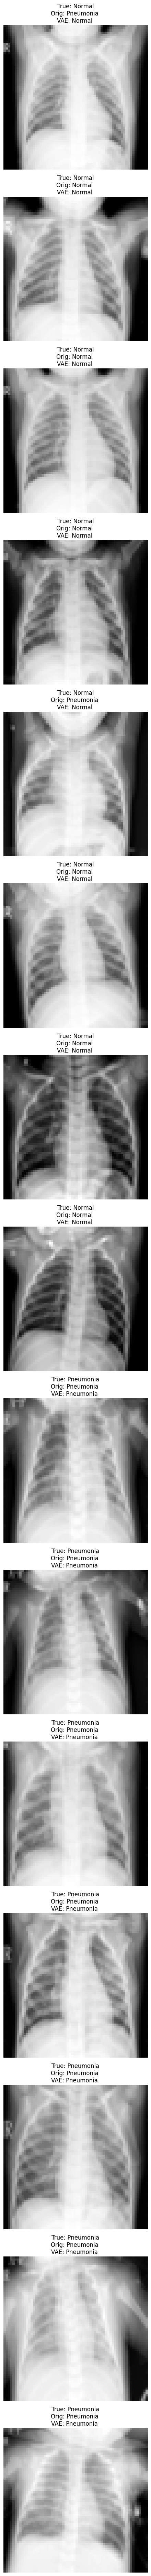

In [47]:
# Visualization
def plot_validation_results(val_loader, cnn_original, cnn_vae, device, num_images=5):
    val_images = []
    val_labels = []
    orig_preds = []
    vae_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val_images.append(images.cpu().squeeze())
            val_labels.append(labels.item())
            orig_pred = torch.argmax(cnn_original(images), dim=1).item()
            vae_pred = torch.argmax(cnn_vae(images), dim=1).item()
            orig_preds.append(orig_pred)
            vae_preds.append(vae_pred)
            if len(val_images) >= num_images:
                break
    
    fig, axes = plt.subplots(num_images, 1, figsize=(5, 5 * num_images))
    for i in range(num_images):
        axes[i].imshow(val_images[i], cmap="gray")
        true_label = "Normal" if val_labels[i] == 0 else "Pneumonia"
        orig_pred = "Normal" if orig_preds[i] == 0 else "Pneumonia"
        vae_pred = "Normal" if vae_preds[i] == 0 else "Pneumonia"
        axes[i].set_title(f"True: {true_label}\nOrig: {orig_pred} \nVAE: {vae_pred} ")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.savefig("val_results.png")
    plt.show()

plot_validation_results(val_loader, cnn_original, cnn_vae, device, num_images=15)